# Coursework 2 QRM

### Q1 part A: Fitting a GARCH(1,1) model to the trainning data

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as ss
import statsmodels.api as sm #For acf plots
from arch.univariate import arch_model #We import the arch package to fit the time series model
from scipy.stats import skew, kurtosis, norm,t # to use the generalised Student-t pdf
from scipy.optimize import minimize #import minimize function from SciPy
#We upload the data
TSLAdata = pd.read_csv('./data/QRM-2022-cw2-data.csv')
TSLAdata['Date'] = pd.to_datetime(TSLAdata['Date'])
TSLAdata.sort_values(by='Date', ascending=True)
TSLAdata.set_index('Date', inplace=True)

#We create the simple and log returns in our panda frame
TSLAdata['simplereturn'] = TSLAdata['TSLA'].pct_change()
TSLAdata['logreturn'] = np.log(TSLAdata['TSLA']).diff()
#TSLAdata['logreturn'] = np.log(1 + TSLAdata['simplereturn'])

# Multiply the return values by 100 so they represent percentage values
TSLAdata['simplereturn']  = TSLAdata['simplereturn']  * 100
TSLAdata['logreturn'] = TSLAdata['logreturn'] * 100

#Calculation of parameters asked
mu = TSLAdata['logreturn'].mean()
sigma = TSLAdata['logreturn'].std()

TSLAdata.head()

# Select DataFrame rows between two dates
start_date_train = '2012-11-26'
end_date_train   = '2021-11-25'
TSLAdata_train = TSLAdata.query('Date >= @start_date_train and Date <= @end_date_train')

start_date_test = '2021-11-26'
end_date_test   = '2022-11-26'
TSLAdata_test = TSLAdata.query('Date >= @start_date_test and Date <= @end_date_test')

garchmodel = arch_model(TSLAdata['logreturn'].dropna(), mean='constant', rescale= 'True', p=1, q=1, dist='normal')
resgarch = garchmodel.fit(update_freq=5)
print(resgarch.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 6895.1504409974
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6571.569532847754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6571.568723403154
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6571.57
Distribution:                  Normal   AIC:                           13151.1
Method:            Maximum Likelihood   BIC:                           13174.5
                                        No. Observations:                 2518
Date:                Wed, Dec 07 2022   Df Residuals:                     2517
Time:            

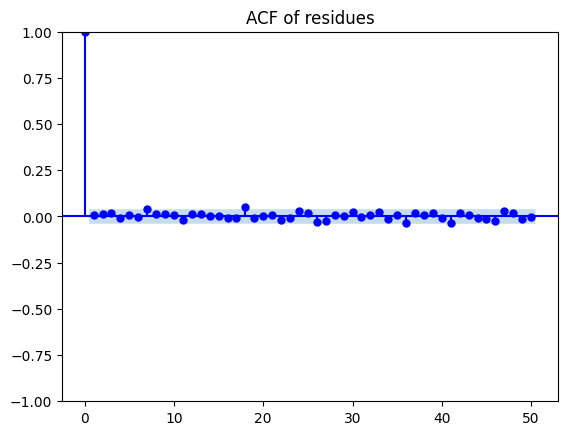

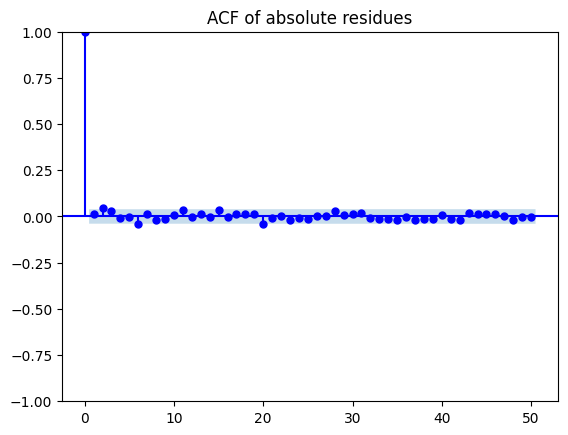

0.0075215752902489455
0.9997464802212899


In [5]:
my_color = 'b'
sm.graphics.tsa.plot_acf(resgarch.std_resid, lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of residues")
plt.show()
sm.graphics.tsa.plot_acf(np.abs(resgarch.std_resid).dropna(), lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of absolute residues")
plt.show()

print(resgarch.std_resid.mean())
print(resgarch.std_resid.std())

The hypothesis of independent seems feasible enough

### Q1 part B: Fitting a normalised student t-distribution

As another exercise, let's fit a student normalised distribution to $(Z_t)_t$. A **normalised Student-t distribution** with degree of freedom $\nu$ and **unit variance**, which pdf is $$f_Z(z)=f_{general-t-dist}\left(z;\text{df}=\nu,\text{location}=0,\text{scale}=\sqrt{\frac{\nu-2}{\nu}}\right)$$ where $f_{general-t-dist}$ is the pdf of a generalised t distribution with degree of freedom $\nu$ and some location and scale parameter.

REMARK: a standard Student-t distribution with degree of freedom $\nu$ has variance $\nu/(\nu-2)$ but not one. If $Y$ is a standard Student-t distribution, we need to construct $Z$ in form of $Z=\sqrt{\frac{\nu-2}{\nu}} Y$ to enforce $var(Z)=1$. Hence $Z$ can be thought as a general t-distribution with location parameter of zero and scale parameter of $\sqrt{\frac{\nu-2}{\nu}}$.

We will use (log-)maximum likelihood for this purposes:

In [8]:
#This is just an attempt to use a package, it does not seem to work
from scipy import stats
dist = getattr(stats, 't')
parameters = dist.fit(resgarch.std_resid.dropna())
print(parameters)

# student_fittet = parameters[0]*


(3.733591881428594, 0.015436259447195327, 0.7028807797475118)


In [ ]:
t.ppf()

In [22]:
from scipy.stats import t # to use the generalised Student-t pdf

x = resgarch.std_resid.dropna()


def garch11_t_loglikelihood(nu, x):
    return np.sum( np.log(t.pdf(x[1:], df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))

objfun_t = lambda y : -1 * garch11_t_loglikelihood(y, x)

y0 = 1
print("Initial objective function value: " + str(objfun_t(y0)))

bnds = [(0.01,np.inf)]


sol = minimize(fun=objfun_t,x0=y0,
            method='SLSQP',bounds=bnds)

print("Estimate of nu: " + str(sol.x[0]))


Initial objective function value: nan
Estimate of nu: 1.0


C:\Users\George\AppData\Local\Temp\ipykernel_17632\2694659104.py:7: RuntimeWarning: invalid value encountered in sqrt
  return np.sum( np.log(t.pdf(x[1:], df=nu, loc=0, scale=np.sqrt((nu-2)/nu))))


In [25]:
#Requires the distribution t previously loaded
def log_likelihood_function_t(nu, x):
    return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) ) 

objfun_loglikelihood_t = lambda y : -1 * log_likelihood_function_t(y, resgarch.std_resid.dropna())

y0 = 2.1

print("Initial objective function value: " + str(objfun_loglikelihood_t(y0)))
bnds = [(0,np.inf)]
con = {'type': 'ineq'} 

sol_loglikelihood = minimize(objfun_loglikelihood_t, y0 ,method='SLSQP',bounds=bnds, options={'disp': True})

print("Estimate of nu: " + str(sol_loglikelihood.x[0]))
print("Solution->",sol_loglikelihood)

Initial objective function value: 4609.513701050104
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3396.185849278615
            Iterations: 17
            Function evaluations: 51
            Gradient evaluations: 17
Estimate of nu: 3.981095811887276
Solution->      fun: 3396.185849278615
     jac: array([0.00311279])
 message: 'Optimization terminated successfully'
    nfev: 51
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([3.98109581])


C:\Users\George\AppData\Local\Temp\ipykernel_17632\3662678008.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) )
C:\Users\George\AppData\Local\Temp\ipykernel_17632\3662678008.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) )


Once the parameter of degreees of freedom is obtained we simply draw a histogram and qqplots with that student t and see if it is a good fit.

### Q1 part C: generalised Pareto distribution (GPD)

In [ ]:
TSLAdata['std_residuals'] = resgarch.std_resid
TSLAdata

In [ ]:
v = np.linspace(0, 6, 100) # some values of v
excess_mean = []

for vv in v:
    excess_mean.append(np.sum((resgarch.std_resid - vv) * (resgarch.std_resid > vv)) / np.sum(resgarch.std_resid > vv))
plt.figure(figsize = (10,10))
plt.plot(v, excess_mean, 'g*')
plt.title("Sample mean excess function")
plt.ylabel("$e_n(v)$")
plt.xlabel("$v$")

In [ ]:
u = 1.2 # our choice of u
y = TSLAdata[TSLAdata['std_residuals'] > u]['std_residuals'] - u # construction of y
print(y)

In [ ]:
def GPD_loglikelihood(y, xi, beta):
    return -len(y) * np.log(beta) - (1 + 1/xi) * np.sum(np.log(1 + xi * y / beta))

objfun = lambda theta : -1 * GPD_loglikelihood(y, theta[0], theta[1]) # theta[0] represents xi and theta[1] represents beta

theta0 = [1, 1]  # initial guess
print("Initial objective function value: " + str(objfun(theta0)))

bnds = ((0.01,20), (0,20)) # individual bound on each parameter

sol = minimize(objfun,theta0,method='SLSQP',bounds=bnds, options={'disp': True})

print("Estimate of xi: " + str(sol.x[0]))
print("Estimate of beta: " + str(sol.x[1]))

In [ ]:
def GPD_cdf(x, xi, beta): # Implement the CDF of GPD
    if xi == 0:
        return 1 - np.exp(-x/beta)
    else:
        return 1 - (1 + xi * x / beta) ** (-1/xi)

xx = np.linspace(0, 70, 10000) # For plotting the theoretical, fitted GPD

# Empirical CDF functionality from the "statsmodels" package
empirical_cdf_obj = sm.distributions.empirical_distribution.ECDF((y.to_numpy()).flatten()) 

fig, ax = plt.subplots()
ax.plot(xx, GPD_cdf(xx, sol.x[0], sol.x[1]), 'k-', label='Fitted') # Plot the CDF of fitted GPD
ax.plot(y, empirical_cdf_obj(y), 'b*', label='Empirical') # Plot the empirical CDF of Y, the excess claim value above u
ax.legend()
ax.set_xscale('log')
ax.set_title('Empirical vs fitted CDF of the excess distribution')
ax.set_ylabel('$F_{u}(x-u)$')
ax.set_xlabel('$x$')
plt.show()

### Q1 part D: computing VaR and ES forecasts.

Compute several sets of VaR and ES forecast on each date in the testing data
set at 95% and 99% confidence levels, based on the following different specifications
of the strict white noise component Z in the GARCH(1,1)model: \ \
I Z follows a standard normal distribution; \ \
I Z follows a normalised Student t distribution; \ \
I Z is such that its excess distribution (over u) is described by GPD. \ \
Describe clearly how you compute the VaR and ES under each specification.
Display the risk forecasts graphically. Backtest the VaR forecasts by considering
unconditional coverage tests only and compare the results under different
specifications.